In [5]:
import sys
import os
sys.path.append(os.path.abspath("..")) 
from scripts.get_paths import get_path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pingouin as pg
from itertools import combinations
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [6]:
paths = get_path()
df = pd.read_csv(paths.features_2 / "extracted_features.csv", index_col=False)

### LIWC https://www.liwc.app/ was used to extract word categories 

In [7]:
# Read the CSV files
liwc_part_1 = pd.read_csv(paths.processed / "transcripts/LIWC/LIWC_part_1_HC.csv")
liwc_part_4 = pd.read_csv(paths.processed / "transcripts/LIWC/LIWC_part_4_HC.csv")
liwc_part_6 = pd.read_csv(paths.processed / "transcripts/LIWC/LIWC_part_6_HC.csv")

# Create the dictionary of dataframes
liwc_dict = {
    "liwc_part_1": liwc_part_1,
    "liwc_part_4": liwc_part_4,
    "liwc_part_6": liwc_part_6
}

# Loop through the dictionary, add the 'participant' column, and display some info
for part_name, liwc_result in liwc_dict.items():
    # Extract the participant from the 'Filename' column
    liwc_result['participant'] = liwc_result['Filename'].str.split('_').str[0]

    # #Check the first few rows after adding the new column
    # print(f"\n{part_name} preview:")
    # display(liwc_result.head())

    # #Print the columns to confirm
    # print(f"Columns in {part_name}: {liwc_result.columns.tolist()}")

### Plot with statistical significance

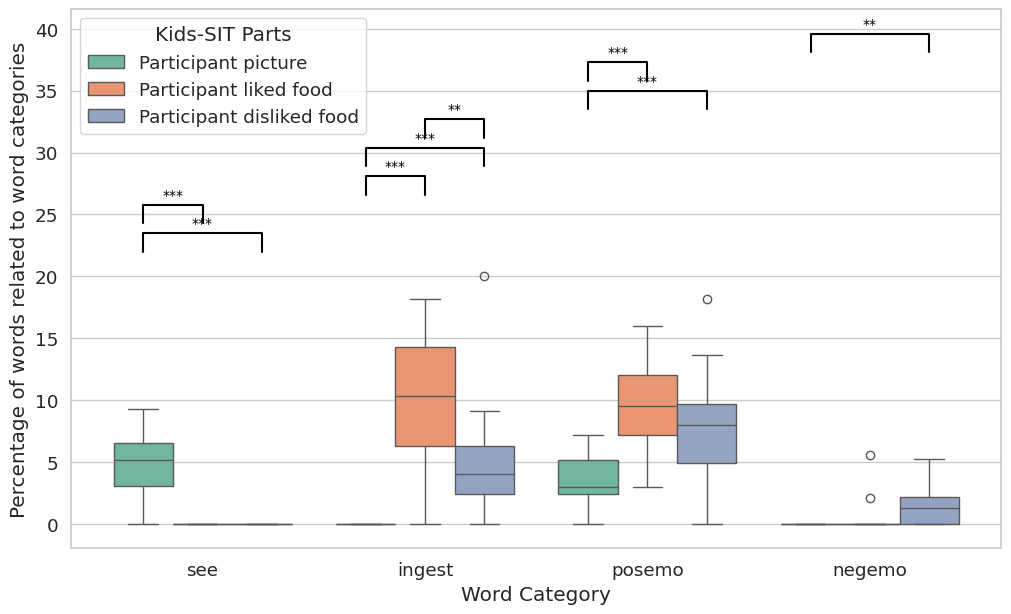

mean  median    min    max
WC     liwc_part_1  45.238095   43.00  14.00  67.00
       liwc_part_4  39.047619   34.00  10.00  95.00
       liwc_part_6  46.857143   47.00  15.00  80.00
posemo liwc_part_1   3.277143    2.94   0.00   7.14
       liwc_part_4   9.661429    9.52   2.94  16.00
       liwc_part_6   7.791905    8.00   0.00  18.18
negemo liwc_part_1   0.000000    0.00   0.00   0.00
       liwc_part_4   0.365238    0.00   0.00   5.56
       liwc_part_6   1.430952    1.30   0.00   5.26
ingest liwc_part_1   0.000000    0.00   0.00   0.00
       liwc_part_4   9.665714   10.34   0.00  18.18
       liwc_part_6   5.188095    4.00   0.00  20.00
see    liwc_part_1   4.917143    5.13   0.00   9.30
       liwc_part_4   0.000000    0.00   0.00   0.00
       liwc_part_6   0.000000    0.00   0.00   0.00

In [8]:
# ===========================
# Categories and Parts
# ===========================
selected_features = ["see", "ingest", "posemo", "negemo"]
part_name_mapping = {
    "liwc_part_1": "Participant picture",
    "liwc_part_4": "Participant liked food",
    "liwc_part_6": "Participant disliked food"
}

# Combine data into one DataFrame
plot_data_list = []
for part, df in liwc_dict.items():
    if part in part_name_mapping:
        for feature in selected_features:
            temp_df = pd.DataFrame({
                "Value": df[feature],
                "Feature": feature,
                "Part": part_name_mapping[part],
                "Participant": df["participant"] if "participant" in df.columns else "Unknown"
            })
            plot_data_list.append(temp_df)

combined_plot_data = pd.concat(plot_data_list)

# ===========================
# Plot style
# ===========================
sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(12, 7))
ax = sns.boxplot(
    x="Feature",
    y="Value",
    hue="Part",
    data=combined_plot_data,
    palette="Set2",
    legend=True
)
ax.set_xlabel("Word Category")
ax.set_ylabel("Percentage of words related to word categories")
# ===========================
# Get x positions of violins
# ===========================
violin_positions = {}
features_order = selected_features
parts_order = list(part_name_mapping.values())
num_parts = len(parts_order)

for i, feature in enumerate(features_order):
    for j, part in enumerate(parts_order):
        # Now grouping by feature on x-axis
        x_pos = i - 0.4 + (j + 0.5) * (0.8 / num_parts)
        violin_positions[(feature, part)] = x_pos

# ===========================
# Statistical tests
# ===========================

feature_pairs_across_parts = []
p_values = []

for feature in selected_features:
    #print(f"\n===== {feature} =====")

    # Subset the data for this feature
    feature_data = combined_plot_data[combined_plot_data['Feature'] == feature]

    # ===========================
    # Normality test per part

    # ===========================
    normality_results = {}
    for part in parts_order:
        part_data = feature_data[feature_data['Part'] == part]['Value']
        if len(part_data) >= 3:  # Shapiro needs at least 3 samples
            stat, pval = stats.shapiro(part_data)
            normality_results[part] = pval
            #print(f"{feature} | {part}: Shapiro p = {pval:.4f}")
        else:
            normality_results[part] = 1  # Treat as normal if not enough data

    is_normal = all(p > 0.05 for p in normality_results.values())

    # ===========================
    # Repeated Measures ANOVA or Friedman
    # ===========================
    if is_normal:
        #print(f"{feature}: Data is normal → Repeated Measures ANOVA")
        rm_anova = pg.rm_anova(dv='Value', within='Part', subject='Participant', data=feature_data, detailed=True)
        #display(rm_anova)

        if 'p-GG-corr' in rm_anova.columns:
            pval_overall = rm_anova.loc[0, 'p-GG-corr']
        else:
            pval_overall = rm_anova.loc[0, 'p-unc']
        if pval_overall < 0.05:
            # Post-hoc pairwise t-tests
            posthocs = pg.pairwise_ttests(
                dv='Value', within='Part', subject='Participant',
                padjust='bonf', data=feature_data, effsize='cohen'
            )
            #display(posthocs)

            # Filter significant pairs
            sig_pairs = posthocs[posthocs['p-corr'] < 0.05]

            for _, row in sig_pairs.iterrows():
                part1 = row['A']
                part2 = row['B']
                pval = row['p-corr']

                feature_pairs_across_parts.append({
                    "feature": feature,
                    "pair": (part1, part2),
                    "pval": pval
                })

                p_values.append(pval)
    else:
        #print(f"{feature}: Data is NOT normal → Friedman Test")
        friedman = pg.friedman(dv='Value', within='Part', subject='Participant', data=feature_data)
        #display(friedman)

        pval_overall = friedman.iloc[0]['p-unc']
        
        if pval_overall < 0.05:
            # Post-hoc pairwise Wilcoxon tests
            pairs = list(combinations(parts_order, 2))
            pairwise_results = []

            for pair in pairs:
                part1, part2 = pair

                # Get participant-wise paired samples
                df1 = feature_data[feature_data['Part'] == part1].sort_values(by='Participant')
                df2 = feature_data[feature_data['Part'] == part2].sort_values(by='Participant')

                # Ensure alignment
                merged = pd.merge(df1[['Participant', 'Value']], df2[['Participant', 'Value']],
                                  on='Participant', suffixes=('_1', '_2'))

                if len(merged) < 1:
                    continue

                stat, pval = stats.wilcoxon(merged['Value_1'], merged['Value_2'])
                pairwise_results.append({
                    "A": part1,
                    "B": part2,
                    "p-unc": pval
                })

            # Convert to DataFrame and apply Bonferroni correction
            pairwise_df = pd.DataFrame(pairwise_results)
            pairwise_df['p-corr'] = pg.multicomp(pairwise_df['p-unc'].values, method='bonf')[1]
            sig_pairs = pairwise_df[pairwise_df['p-corr'] < 0.05]

            #display(sig_pairs)

            for _, row in sig_pairs.iterrows():
                part1 = row['A']
                part2 = row['B']
                pval = row['p-corr']

                feature_pairs_across_parts.append({
                    "feature": feature,
                    "pair": (part1, part2),
                    "pval": pval
                })

                p_values.append(pval)

# ===========================
# Add significance brackets
# ===========================
y_offset_start = combined_plot_data["Value"].max() + 2
y_step = 1.5
y_offset = y_offset_start

for idx, item in enumerate(feature_pairs_across_parts):
    part1, part2 = item["pair"]
    feature = item["feature"]
    corrected_pval = item["pval"]

    if corrected_pval >= 0.05:
        continue

    if corrected_pval < 0.001:
        marker = "***"
    elif corrected_pval < 0.01:
        marker = "**"
    elif corrected_pval < 0.05:
        marker = "*"

    x1 = violin_positions[(feature, part1)]
    x2 = violin_positions[(feature, part2)]

    ax.plot([x1, x1, x2, x2], [y_offset, y_offset + y_step, y_offset + y_step, y_offset],
            lw=1.5, color='black')

    ax.text((x1 + x2) / 2, y_offset + y_step + 0.2, f"{marker}",
            ha='center', va='bottom', color='black', fontsize=10)

    y_offset += y_step + 0.8

legend = ax.get_legend()
legend.set_title("Kids-SIT Parts")
# Show the plot
plt.show()
# Define relevant features
features = ["WC", "affect", "posemo", "negemo", "ingest", "see", "filler"]
features = ["WC", "posemo", "negemo", "ingest", "see"]
# Compute functionals and store them
functional_results = {}
for feature in features:
    functional_results[feature] = {
        part: {
            "mean": df[feature].mean(),
            "median": df[feature].median(),
            "min": df[feature].min(),
            "max": df[feature].max()
        } for part, df in liwc_dict.items()
    }

# Convert functionals to DataFrame and display
functional_df = pd.DataFrame.from_dict({(feature, part): values 
                                        for feature, parts in functional_results.items() 
                                        for part, values in parts.items()}, orient='index')
display(functional_df)